# Basic Analysis of Port of LA Water Quality Database

In this analysis we will load the tidy version of the POLA database, created in another notebook, and do some basic regression analysis, looking at the relationships between measurements. 


In [1]:
# Imports should be collected at the top, as a standard programming convention

# This turns off a warning about a deprecation in Pandas, from coude referenced by Statsmodel. 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# These imports are the most common for data analysis, 
# and they are given standard aliases. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For other imports, we only need one or two 
# functions, rather than the whole module. 
from scipy.stats import zscore
from pathlib import Path
from os import environ

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from statsmodels.formula.api import ols

# Wrangling

The first step in any analysis is to clean up the data and get it into a form that is useful for analysis. The standard for for data analysis is for each row to be an observation and each coumn to represent a measured value. Recently, this form has come to be known as the "tidy" form, aster a 2013 article describing the format. 

THe POLA data, in contrast, is in "long form", where one column describes the type of measurement, and another column has the result value for multiple measurements. Furthermore, the POLA data is split across multipe files. The whole dataset is small, less than 1m rows, so we will combine all of the files into a single dataframe, then convert to tidy format. 


In [2]:
# First we will load the datasets, combine them, and do some cleanup. 

# The directory in Google Drive where our files are stored. 

if Path('/gdrive').is_dir():
    data_dir = Path('/gdrive/Shared drives/Wood/Data/')
    
elif environ.get('WOODPLC_DATA_DIR'):
    # To run locally, download the Woodplc data directory, or setup Google Drive Stream to mount it, 
    # then set the environmental variable to the directory   
    data_dir = Path(environ.get('WOODPLC_DATA_DIR'))
    
pola_data_dir = data_dir.joinpath('POLA Water Quality Database Files/CTD Files Organized for Python/Ready for Access')

# Tidy dataset, with all data
pola = pd.read_csv(data_dir.joinpath('pola_tidy.csv'), parse_dates=['datetime']).set_index(['sitename','datetime'])

# Tidy dataset, with outliers removed
pola_no = pd.read_csv(data_dir.joinpath('pola_tidy_no.csv'), parse_dates=['datetime']).set_index(['sitename','datetime'])

#Faked data, has linear relationship of DO to other variables. 
pola_t = pd.read_csv(data_dir.joinpath('pola_faked.csv')).set_index(['sitename','datetime'])

pola.head()


index  depth  dissolved_oxygen  fluorescence  \
sitename datetime                                                            
AS1      2018-07-17 11:49:00      0    0.5           7.16056        2.9065   
         2018-07-17 11:49:00      1    1.0           7.17666        3.0533   
         2018-07-17 11:49:00      2    1.5           7.13837        3.4530   
         2018-07-17 11:49:00      3    2.0           7.10275        4.0010   
         2018-07-17 11:49:00      4    2.5           7.06786        4.6305   

                                 ph  salinity  temperature  transmissivity  \
sitename datetime                                                            
AS1      2018-07-17 11:49:00  8.094   33.6155      19.9630         75.6053   
         2018-07-17 11:49:00  8.090   33.6125      19.9335         75.3734   
         2018-07-17 11:49:00  8.091   33.5674      19.7881         75.6926   
         2018-07-17 11:49:00  8.088   33.5984      19.6458         75.8661   
         2018-07-17 11:49:00  8.090   33.6125      19.5989         75.8419   

                              turbidity  
sitename datetime                        
AS1      2018-07-17 11:49:00   0.671335  
         2018-07-17 11:49:00   0.883069  
         2018-07-17 11:49:00   0.883727  
         2018-07-17 11:49:00   0.734444  
         2018-07-17 11:49:00   0.817684

# Descriptive


In [3]:
# Tidy dataset, with outliers
pola.describe()

,index,depth,dissolved_oxygen,fluorescence,ph,salinity,temperature,transmissivity,turbidity
count,86883.000000,86883.000000,86191.000000,86191.000000,86181.000000,86184.000000,86191.000000,86191.000000,81818.000000
mean,43441.000000,7.210621,4.848246,1.800437,7.980318,33.296879,16.496583,70.444513,2.585758
std,25081.106056,22.492295,130.009563,2.164946,0.372699,8.930027,2.196529,11.199334,30.525673
min,0.000000,0.500000,-38160.000000,-11.698200,-3.627000,2.060200,-98.976200,-61.806200,-258.485180
25%,21720.500000,3.022000,3.975900,0.791300,7.790000,33.180975,14.991900,65.297100,0.850299
50%,43441.000000,6.500000,5.465880,1.250900,7.950000,33.325000,16.163500,71.929000,1.219774
75%,65161.500000,10.500000,6.454395,2.147900,8.129000,33.441800,18.107000,77.611550,1.786680
max,86882.000000,3635.000000,24.022910,190.597600,9.112000,2000.000000,25.735000,112.832000,1485.114100


In [4]:
# Tidy dataset, outliers removed
pola_no.describe()

,depth,dissolved_oxygen,fluorescence,ph,salinity,temperature,transmissivity,turbidity
count,86879.000000,85891.000000,85935.000000,86078.000000,86179.000000,86189.000000,86157.000000,81723.000000
mean,7.062379,5.311845,1.738167,7.986383,33.245095,16.498197,70.473253,1.587678
std,4.619183,1.580799,1.544605,0.312214,0.613241,2.159556,11.105708,3.112880
min,0.500000,1.067220,-5.913700,6.081000,2.060200,8.846500,3.659200,-61.955521
25%,3.021500,3.987150,0.790200,7.791000,33.180900,14.991900,65.306100,0.849862
50%,6.500000,5.475370,1.248100,7.950000,33.325000,16.163500,71.934500,1.218972
75%,10.500000,6.458165,2.139000,8.130000,33.441800,18.107000,77.613600,1.782707
max,26.500000,12.799640,14.771200,9.112000,48.576000,25.735000,112.832000,182.780770


# Correlations



In [5]:

tc = pola_no.corr()

# Create an upper triangle matrix, so we can select only part
# of the correlation matrix
tc



,depth,dissolved_oxygen,fluorescence,ph,salinity,temperature,transmissivity,turbidity
depth,1.000000,0.006694,-0.107947,-0.027131,0.093424,-0.224810,0.125777,-0.065005
dissolved_oxygen,0.006694,1.000000,0.240714,0.368124,0.037413,-0.122947,-0.084271,0.045950
fluorescence,-0.107947,0.240714,1.000000,0.155382,0.132550,0.108687,-0.231159,-0.005263
ph,-0.027131,0.368124,0.155382,1.000000,0.109911,0.014469,-0.113034,0.002736
salinity,0.093424,0.037413,0.132550,0.109911,1.000000,0.096755,0.005105,-0.018820
temperature,-0.224810,-0.122947,0.108687,0.014469,0.096755,1.000000,0.000716,-0.050213
transmissivity,0.125777,-0.084271,-0.231159,-0.113034,0.005105,0.000716,1.000000,-0.290670
turbidity,-0.065005,0.045950,-0.005263,0.002736,-0.018820,-0.050213,-0.290670,1.000000


In [6]:
# This is a good application for table styling. 

tc.style.background_gradient(cmap='plasma', axis=1)


,depth,dissolved_oxygen,fluorescence,ph,salinity,temperature,transmissivity,turbidity
depth,1,0.00669402,-0.107947,-0.0271314,0.0934236,-0.22481,0.125777,-0.0650053
dissolved_oxygen,0.00669402,1,0.240714,0.368124,0.0374127,-0.122947,-0.0842705,0.0459496
fluorescence,-0.107947,0.240714,1,0.155382,0.13255,0.108687,-0.231159,-0.00526322
ph,-0.0271314,0.368124,0.155382,1,0.109911,0.0144687,-0.113034,0.00273562
salinity,0.0934236,0.0374127,0.13255,0.109911,1,0.0967549,0.00510531,-0.0188202
temperature,-0.22481,-0.122947,0.108687,0.0144687,0.0967549,1,0.000715958,-0.0502131
transmissivity,0.125777,-0.0842705,-0.231159,-0.113034,0.00510531,0.000715958,1,-0.29067
turbidity,-0.0650053,0.0459496,-0.00526322,0.00273562,-0.0188202,-0.0502131,-0.29067,1


This routine will to the complete correlations between all columns, but then eliminate the duplicates and show them in a table format. 

In [7]:

def minimal_corr(df):
    

    tcr = df.corr()                        # Create a correlation matrix

    # Create an upper triangle matrix, so we can select only part
    # of the correlation matrix
    keep = (np.triu(np.ones(tcr.shape))   # Make a triangular matrix of 1 and 0
            .astype('bool')               # Convert it to bool
            .reshape(tcr.size))           # Turn it from a matrix to a 1D series

    tc = (tcr.stack()                     # Convert from a matris to a 1D series, with rows and col labels as row indexes
            [keep]                        # Select just the rows selected by the trianular matrix
            .to_frame('result'))          # Convert the series into a dataframe

    t = tc[tc.result<1].sort_values('result',ascending=False).reset_index()

    return t[np.abs(t.result) > .1]

# Correlations with the outliers
minimal_corr(pola)

,level_0,level_1,result
0,depth,salinity,0.404078
1,fluorescence,turbidity,0.248893
2,dissolved_oxygen,temperature,0.177408
3,index,temperature,0.107757
30,depth,temperature,-0.135612
31,salinity,temperature,-0.153587
32,fluorescence,transmissivity,-0.187717
33,index,transmissivity,-0.228615
34,depth,dissolved_oxygen,-0.534584
35,dissolved_oxygen,salinity,-0.750398


In [8]:
# Correlations without the outliers. Note that the correlatinos are completely different. 

minimal_corr(pola_no)

,level_0,level_1,result
0,dissolved_oxygen,ph,0.368124
1,dissolved_oxygen,fluorescence,0.240714
2,fluorescence,ph,0.155382
3,fluorescence,salinity,0.132550
4,depth,transmissivity,0.125777
5,ph,salinity,0.109911
6,fluorescence,temperature,0.108687
22,depth,fluorescence,-0.107947
23,ph,transmissivity,-0.113034
24,dissolved_oxygen,temperature,-0.122947


In [9]:
minimal_corr(pola_no[pola.ph > 7.5])

,level_0,level_1,result
0,dissolved_oxygen,ph,0.429671
1,dissolved_oxygen,fluorescence,0.242001
2,fluorescence,ph,0.161938
3,fluorescence,salinity,0.132847
4,depth,transmissivity,0.124028
5,ph,salinity,0.122254
6,fluorescence,temperature,0.109280
22,depth,fluorescence,-0.108556
23,dissolved_oxygen,temperature,-0.124746
24,ph,transmissivity,-0.135053


# Timeseries

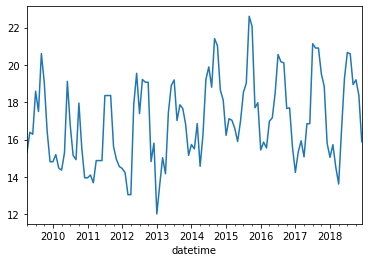

In [10]:
t = pola_no.set_index('depth',append=True).loc[('LA10',slice(None),1.0)].reset_index([0,2]).resample('M').mean()
t.temperature.fillna(method='pad').plot()

In [11]:
t

,depth,dissolved_oxygen,fluorescence,ph,salinity,temperature,transmissivity,turbidity
datetime,,,,,,,,
2009-04-30,1.0,8.35284,5.03900,8.569,33.6182,15.3009,67.24190,1.534291
2009-05-31,1.0,5.47000,1.21340,8.501,33.6279,16.3928,71.32570,2.601447
2009-06-30,1.0,5.97231,0.63690,8.701,33.5914,16.2859,68.89990,3.027043
2009-07-31,1.0,6.49331,0.74520,8.614,33.5420,18.5910,72.07420,2.332522
2009-08-31,1.0,3.59833,1.03120,8.509,33.4286,17.5037,63.28840,2.407445
2009-09-30,1.0,8.18083,0.59240,8.149,33.3633,20.6087,69.15450,1.400290
2009-10-31,1.0,7.23905,3.57160,8.229,33.3182,19.0627,73.35570,0.635818
2009-11-30,1.0,7.69029,1.03550,8.232,33.3083,16.4435,78.73890,0.683482
2009-12-31,1.0,7.81960,0.64740,8.240,33.0725,14.8146,77.76650,-0.350823


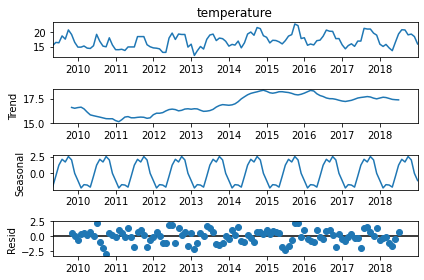

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

t = pola.set_index('depth',append=True).loc[('LA10',slice(None),1.0)].reset_index([0,2]).resample('M').mean()
result = seasonal_decompose(t.temperature.fillna(method='pad'), model='additive')
result.plot();

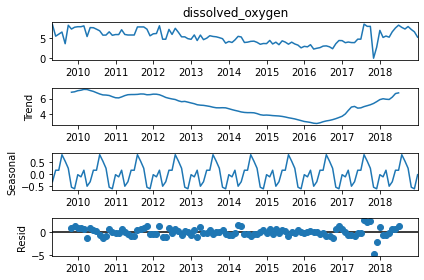

In [13]:
result = seasonal_decompose(t.dissolved_oxygen.fillna(method='pad'), model='additive')
result.plot();

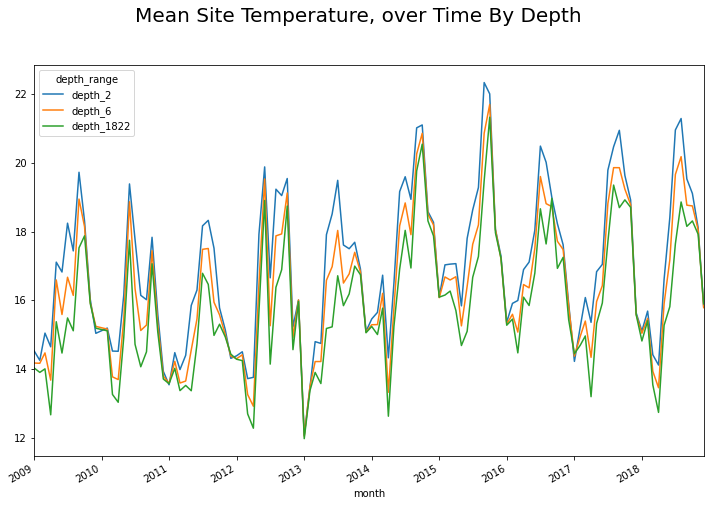

In [14]:
t = pola.copy().reset_index()
t['month'] = pd.DatetimeIndex(t.datetime).to_period("M").to_timestamp()
t['depth_range'] = pd.qcut(t.depth, 3).apply(lambda r: f"depth_{int(round(r.mid,0))}")
t = t.groupby(['month', 'depth_range']).temperature.mean().to_frame()
t = t.unstack()
t.columns = t.columns.droplevel(0)

fig, ax = plt.subplots(figsize=(12,8))
t.plot(ax=ax)

fig.suptitle('Mean Site Temperature, over Time By Depth', fontsize=20);

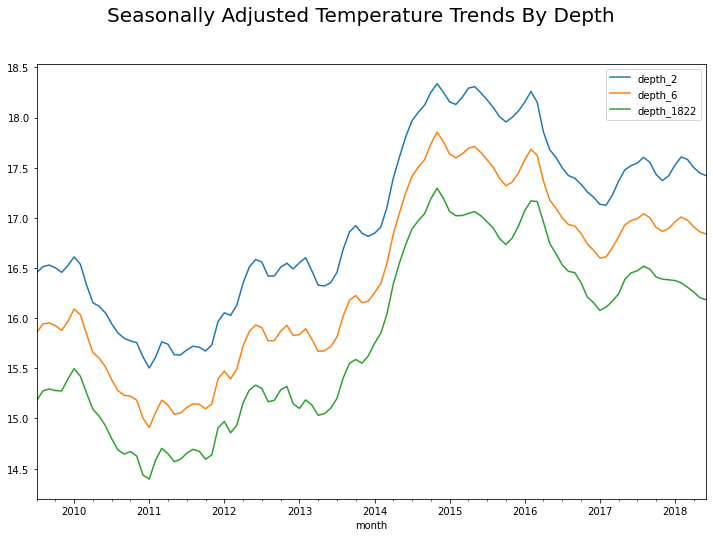

In [15]:
t = t.resample('M').mean() # To get frequency on the index, required for seasonal_decomp
trend_depth = {}
for c in t.columns:
    seasn = seasonal_decompose(t[c].fillna(method='pad'), model='additive')
    trend_depth[c] = seasn.trend

trends = pd.DataFrame(trend_depth)

fig, ax = plt.subplots(figsize=(12,8))
trends.dropna().plot(ax=ax)

fig.suptitle('Seasonally Adjusted Temperature Trends By Depth', fontsize=20);

# Ordinary Least Squares Regression

In [16]:
m = ols('dissolved_oxygen ~ ph', data=pola).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       dissolved_oxygen   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     647.3
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          2.84e-142
Time:                        16:01:55   Log-Likelihood:            -5.4146e+05
No. Observations:               86181   AIC:                         1.083e+06
Df Residuals:                   86179   BIC:                         1.083e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -235.5357      9.458    -24.903      0.000    -254.074    -216.998
ph            30.1221      1.184     25.443      0.000      27.802      32.443
==============================================================================
Omnibus:                   467846.522   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   25935726661482.875
Skew:                        -290.507   Prob(JB):                         0.00
Kurtosis:                   84987.342   Cond. No.                         174.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
from statsmodels.formula.api import ols
m = ols('dissolved_oxygen ~ ph + fluorescence + temperature', data=pola).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       dissolved_oxygen   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1550.
Date:                Fri, 17 Jul 2020   Prob (F-statistic):               0.00
Time:                        16:01:55   Log-Likelihood:            -5.3952e+05
No. Observations:               86181   AIC:                         1.079e+06
Df Residuals:                   86177   BIC:                         1.079e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -411.6785      9.729    -42.316      0.000    -430.746    -392.611
ph              31.5385      1.162     27.146      0.000      29.261      33.816
fluorescence    -6.9177      0.200    -34.542      0.000      -7.310      -6.525
temperature     10.7475      0.197     54.606      0.000      10.362      11.133
==============================================================================
Omnibus:                   459075.754   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   21562507315612.500
Skew:                        -271.036   Prob(JB):                         0.00
Kurtosis:                   77491.787   Cond. No.                         421.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
m = ols('dissolved_oxygen ~ ph + fluorescence + temperature', data=pola_t).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       dissolved_oxygen   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                 1.643e+05
Date:                Fri, 17 Jul 2020   Prob (F-statistic):               0.00
Time:                        16:01:55   Log-Likelihood:                -14973.
No. Observations:               85544   AIC:                         2.995e+04
Df Residuals:                   85540   BIC:                         2.999e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -6.9112      0.026   -261.469      0.000      -6.963      -6.859
ph               1.7106      0.003    536.301      0.000       1.704       1.717
fluorescence     0.2086      0.001    320.312      0.000       0.207       0.210
temperature     -0.1094      0.000   -237.881      0.000      -0.110      -0.108
==============================================================================
Omnibus:                    75679.542   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5131.293
Skew:                          -0.004   Prob(JB):                         0.00
Kurtosis:                       1.800   Cond. No.                         500.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
reg.coef_

NameError: name 'reg' is not defined

In [ ]:
t = pola_no.reset_index()
#t = t[t.sitename == "LA10"]
m = ols('dissolved_oxygen ~ ph + fluorescence + temperature + sitename', data=t).fit()
m.summary()

In [ ]:
m.params

# Linear Regression

In [ ]:


def sample_scores(df, lm, fq, x_cols):
    
    df = df.reset_index()
    
    
    t = df.dropna(subset=list(x_cols)+[fq])
    
    train = t.sample(frac=.7)
    
    X = train[[c for c in x_cols if c != fq]]
    y = train[fq] # [[c for c in train.columns if c.startswith('y')]]

    reg = lm.fit(X, y)

    test = t.loc[~t.index.isin(train.index)]

    X = test[[c for c in x_cols  if c != fq ]]
    y = test[fq]

    return reg.score(X, y)

def run_samples(df, lm, fq, x_cols, iterations=80):
    s = pd.Series([sample_scores(df, lm, fq, x_cols) for _ in range(iterations)])
    
    return s,s.mean(), s.std()

def plot_scores(df, lm, fq, x_cols, title = 'Coef of Determination', ax=None, iterations=80):
    
    s, mean, std = run_samples(df, lm, fq, x_cols, iterations)
    
    ax0 = sns.distplot(s)
    
    if not ax:
        ax = ax0
    
    if (ax and title):
        ax.set_title(f"{title} $\mu$={round(mean,4)}, std={round(std, 3)}")


lm = LinearRegression()

plot_scores(tidy, lm, 'dissolved_oxygen', ['ph'])



For this plot, the function runs multiple iterations where, for each iteration, it select 70% of the records from the `tidy` dataset and tries to fit a linear model -- a line -- to the independent variables ( ``ph`` ) to produce the values of the dependent variable ( ``dissolved_oxygen`` ). Then, it tries to use the linear model to predict the remaining values of the dependent variable. Because the values for the dependent value is already known, the routine can check how good the prediction is. 

With only one dependent variable and one independent variable, the linear model is nothing more than $y=mx+b$, the linear equation we all learned in grade school. The fitting procedure tries to find values of $m$ and $b$ that reduce the error between the values produced by the equation and known values of the dependent variable, ``dissolved_oxygen``. That is, it tries to find values of $m$ and $b$ such that the value of $m*{ph} + b$, for each values of ``ph``, is as close as possible to the value sof ``disolved_oxygen`` that is associated with the value of ``ph``. 

After estimating $m$ and $b$ for 70% of the records, the routine scores the fit by testing it against the remaining 30% of the records. The score value is the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), also known as $R^2$. $R^2$ is the portion of the variance of the dependent variable that is explained by the linear model. We'll get a slightly different value for each diferent iteration, because the routine selects a different 70% of records each time. The plot shows the distribution of scores, and their standard deviation, giving us a more accurate estimate of how good the fit is. 

In this case, the value fir ``ph`` only explains 18% of the variance in dissolved oxygen, so it isn't a very good predictor. Fortunately, we can do linear regression on multiple independent variables, so let's add a few more. 

In [ ]:
# Note that our R^2 above is 0.1762, and the correlation, R is .420937
# These Rs are the same!

np.round(tidy.ph.corr(tidy.dissolved_oxygen) **2, 4)


In [ ]:
plot_scores(tidy, lm, 'dissolved_oxygen', ['fluorescence'])

In [ ]:
np.round(tidy.fluorescence.corr(tidy.dissolved_oxygen) **2, 4)

In [ ]:
plot_scores(tidy, lm, 'dissolved_oxygen', ['ph','depth','temperature', 'transmissivity'])

That wasn't much better, so lets try using all of the remaining variables. The routine will automatically exclude the dependent variable from the input, so we don't have to remove ``disolved_oxygen`` from ``tidy.columns``

In [ ]:
plot_scores(tidy, lm, 'dissolved_oxygen', tidy.columns)

This somewhat better, with about 25% of the variance explained. In the social sciences, this would be a publishable result, but in the physical science, it means that we are missing an important part of the physical process. 

Perhaps we can run this routine for each of the measurements in turn, to determine which of the measurements is best explained by the others.


In [ ]:
# How much variance of each variable is explained by the remaining variables?
rows = []
for c in tidy.columns:
    s, mean, std = run_samples(tidy, lm, c, tidy.columns, iterations=20)
    rows.append({'measure':c, "r2":mean})
    
xr = pd.DataFrame(rows).sort_values('r2', ascending=False)
xr

Well, dissolved oxygen has the strongest dependence on other measures, but pH is a close second. 

In [ ]:
plot_scores(tidy, lm, 'ph', tidy.columns)

# Distplots


In [ ]:

sns.scatterplot('dissolved_oxygen','ph', data=pola_no.reset_index()).set_title('Scatterplot of pH vs Dissolved Oxygen', fontsize=18)

In [ ]:
pola_no[pola_no.ph < 7.5].reset_index().datetime.value_counts().head(40).sort_index()

In [ ]:
g = sns.jointplot('dissolved_oxygen','ph',  kind="hex", color="#4CB391", data=pola )
g.fig.suptitle('Hex Dist Plot of pH vs Dissolved Oxygen', fontsize=18)

In [ ]:
g =sns.jointplot('dissolved_oxygen','ph',  kind="hex", color="#4CB391", data=pola_t )
g.fig.suptitle('Hex Dist Plot of pH vs Dissolved Oxygen (Test Data)', fontsize=18)

In [ ]:
g = sns.jointplot('dissolved_oxygen','ph',  kind="kde",  data=pola)
g.fig.suptitle('KDE Dist Plot of pH vs Dissolved Oxygen', fontsize=18)

In [ ]:
sns.jointplot('dissolved_oxygen','ph',  kind="kde",  data=pola_t)

#

In [21]:
pola_no.groupby(['sitename').depth.max()

sitename
AS1      13.5
AS2      13.5
LA01     26.5
LA03     22.0
LA05     16.0
LA06     12.0
LA10     26.0
LA11A     7.5
LA14      7.5
LA18     18.0
LA19     13.0
LA22A    18.0
LA23     17.0
LA24     17.0
LA26     18.5
LA30     19.0
LA32B    16.5
LA33     18.5
LA35     17.5
LA39     17.5
LA41     18.5
LA44     13.5
LA46     14.0
LA47     18.5
LA49     15.0
LA49A     6.5
LA50     13.5
LA51      9.0
LA55     18.5
LA58     16.0
LA59      8.5
LA60      6.0
LA61      7.0
LA62     18.0
LB23     16.5
Name: depth, dtype: float64

In [23]:
pola_no[pola_no['sitename']=='LA10']

KeyError: 'sitename'

In [27]:
t = pola_no.reset_index()
t = t[t.sitename=='LA10']
t.groupby(t.datetime.dt.month).depth.max()

datetime
1     24.5
2     24.0
3     24.5
4     24.0
5     24.0
6     25.5
7     24.5
8     26.0
9     24.0
10    25.0
11    23.5
12    23.5
Name: depth, dtype: float64